In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [147]:
#S: spot price
#K: strike price
#T: time to maturity
#r: risk free rate
#vol: volatility of underlying asset, sigma standard deviation
# n: number of periods or number of time steps  
#payoff: call or put

S = 250.0      # spot stock price
S0 = 250.0      # initial stock price
K = 250.0               # strike
T = 1.0                 # maturity 
r = 0.03                 # risk free rate 
sigma = 0.15               # standard deviation (volatility)
N = 3                   # number of periods or number of time steps  
payoff = "call"          # payoff 

In [149]:
# Black-Scholes Model

def hypothetical_option(S, K, T, r, sigma, payoff):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

option_value = hypothetical_option(S, K, T, r, sigma, payoff)

In [151]:
option_value

18.712718984781503

In [153]:
S = np.linspace(150,350,11)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = hypothetical_option(S[i], 250, 1, 0.03, 0.15, 'call')

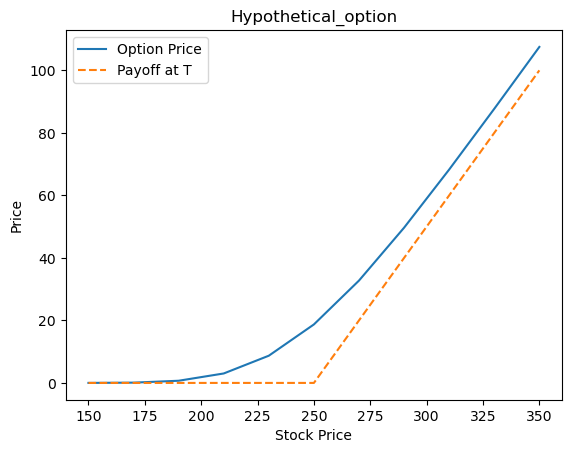

In [155]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-250,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('Hypothetical_option')
plt.legend(['Option Price','Payoff at T'])

In [157]:
#Binomial Tree

dT = float(T) / N                             # Delta t
u = np.exp(sigma * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [159]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = 250
z = 1
for t in range(1, N + 1): #looping forwards, from 1 to N
    for i in range(z):  #looping forwards, from 0 to z-1
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1  # same as z=z+1

In [161]:
S

array([[250.        , 272.61579462, 297.27748591, 324.17015218],
       [  0.        , 229.26037754, 250.        , 272.61579462],
       [  0.        ,   0.        , 210.24128285, 229.26037754],
       [  0.        ,   0.        ,   0.        , 192.79998353]])

In [163]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.5363150857066712

In [165]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        , 74.17015218],
       [ 0.        ,  0.        ,  0.        , 22.61579462],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [167]:
# for European Option
for j in range(N-1, -1, -1): # Column. looping backwards. From N-1 to 0
    for i in range(j+1):  # Row. looping forwards. From 0 to j
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]) #the theoretical value at each node.
V

array([[19.88498309, 31.93692585, 49.76502747, 74.17015218],
       [ 0.        ,  6.37625957, 12.00850436, 22.61579462],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [169]:
print('Hypothetical_option '  + payoff, str( V[0,0]))

Hypothetical_option call 19.8849830923672


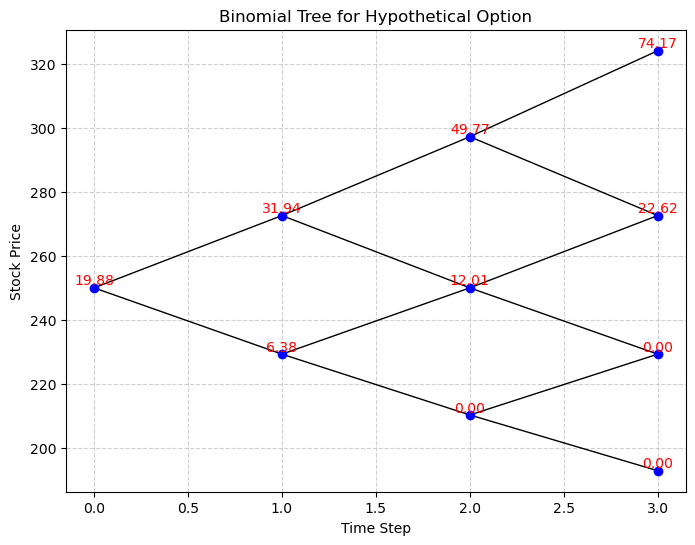

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))
for t in range(N + 1):
    for i in range(t + 1):
        plt.scatter(t, S[i, t], color="blue", zorder=3)
        plt.text(t, S[i, t], f"{V[i, t]:.2f}", fontsize=10, ha='center', va='bottom', color="red")
        if t < N:
            plt.plot([t, t + 1], [S[i, t], S[i, t] * u], "k-", lw=1)
            plt.plot([t, t + 1], [S[i, t], S[i, t] * d], "k-", lw=1)

plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Binomial Tree for Hypothetical Option")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [31]:
# Monte Carlo Simulation
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])    
        # Price process, see Hilpisch (2015) chapter 1 (equation 1-1) & chapter 3 (equation 3-6)
    return S

In [43]:
S = mcs_simulation_np(20000)

In [45]:
S = np.transpose(S)
S

array([[250.        , 249.84078111, 249.71897465, ..., 335.99339785,
        336.01801391, 336.49886028],
       [250.        , 249.70833312, 249.39748233, ..., 300.04625601,
        300.11330102, 300.1478552 ],
       [250.        , 250.16984284, 250.45625936, ..., 307.66424183,
        307.27157434, 307.11032019],
       ...,
       [250.        , 250.17919239, 250.0773868 , ..., 254.14912351,
        254.23354671, 254.38534355],
       [250.        , 249.79517008, 249.47546151, ..., 227.92716106,
        228.03991776, 228.30168396],
       [250.        , 249.61824001, 249.81219198, ..., 299.11321808,
        299.33806078, 299.49234352]])

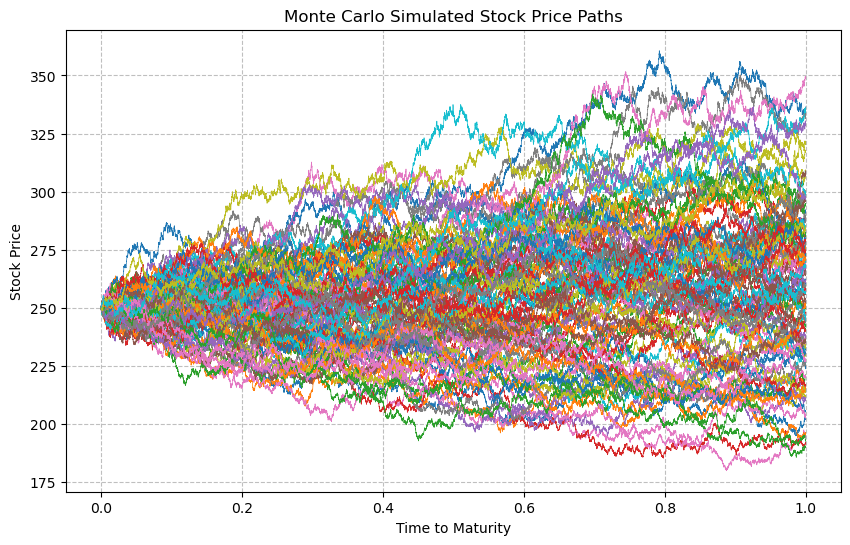

In [47]:
# Plot individual stock price simulations
plt.figure(figsize=(10, 6))
time_steps = np.linspace(0, T, S.shape[1])
for i in range(100):  # Plot first 100 simulated paths
    plt.plot(time_steps, S[i], lw=0.5)
plt.xlabel('Time to Maturity')
plt.ylabel('Stock Price')
plt.title('Monte Carlo Simulated Stock Price Paths')
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

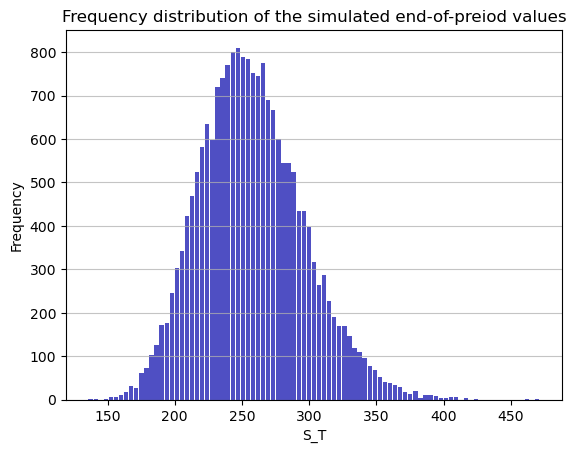

In [49]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [51]:
c = np.exp(-r*T)*np.mean(np.maximum(S[:,-1] - K,0))
print('Hypothetical_option ' + payoff, str(c))

Hypothetical_option call 18.642112352544128


In [ ]:
# At 1000: 19.598843636624682
# At 10000: 18.96187137697321
# At 20000: 18.642112352544128

In [53]:
#Greeks

In [59]:
def hypothetical_option(S, K, T, r, sigma, payoff):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [63]:
hypothetical_option(250, 250, 1, 0.03, 0.15, 'call')

18.712718984781503

In [65]:
hypothetical_option(250, 250, 1, 0.03, 0.15, 'put')

11.32410237190858

In [71]:
S = np.linspace(150,350,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call[i] = hypothetical_option(S[i], 250, 1, 0.03, 0.15, 'call')
    Put[i] = hypothetical_option(S[i], 250, 1, 0.03, 0.15, 'put')

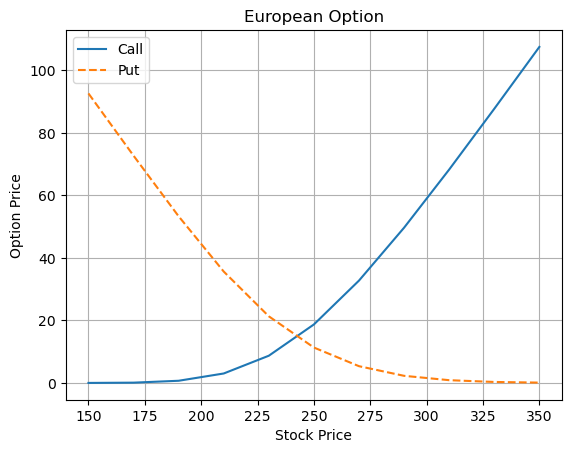

In [73]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Call','Put'])

In [75]:
#Delta

def delta(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  si.norm.cdf(d1, 0.0, 1.0)-1
    
    return delta

In [77]:
delta(250, 250, 1, 0.03, 0.15, 'call')

0.6083418808463947

In [79]:
delta(250, 250, 1, 0.03, 0.15, 'put')

-0.39165811915360527

In [81]:
S = np.linspace(150,350,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 250, 1, 0.03, 0.15, 'call')
    Delta_Put [i] = delta(S[i], 250, 1, 0.03, 0.15, 'put')

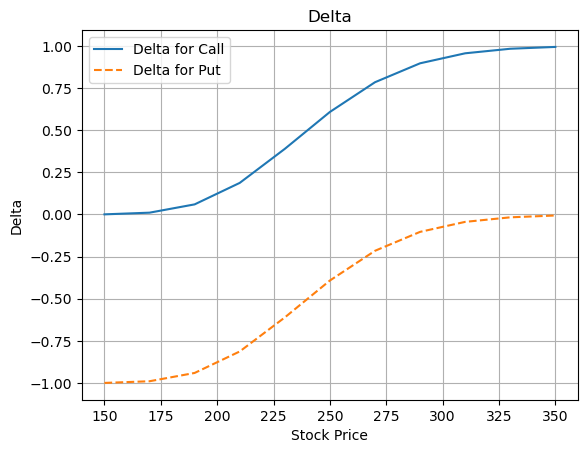

In [83]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [85]:
#Gamma

def gamma(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (sigma *  np.sqrt(T) * S)
    
    return gamma

In [87]:
gamma(250, 250, 1, 0.03, 0.15, 'call')

0.010243704408152128

In [89]:
gamma(250, 250, 1, 0.03, 0.15, 'put')

0.010243704408152128

In [91]:
S = np.linspace(150,350,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 250, 1, 0.03, 0.15, 'call')

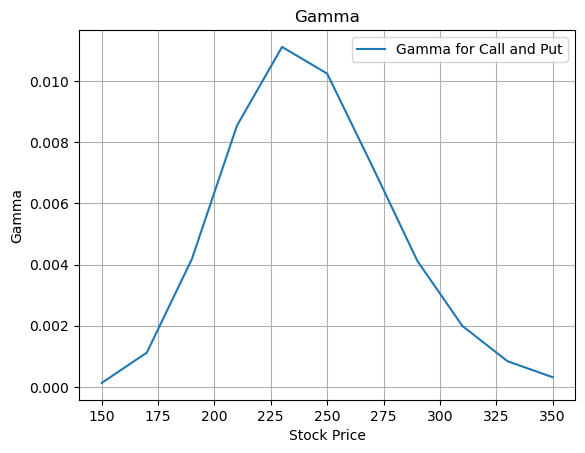

In [93]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [95]:
#Theta

def theta(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    
    if payoff == "call":
        theta = - S * N_d1_prime * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - S * N_d1_prime * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [97]:
theta(250, 250, 1, 0.03, 0.15, 'call')

-11.203787198786479

In [99]:
theta(250, 250, 1, 0.03, 0.15, 'put')

-3.9254456971726674

In [117]:
T = np.linspace(0.25,4,16)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(250, 250, T[i], 0.03, 0.15, 'call')
    Theta_Put [i] = theta(250, 250, T[i], 0.03, 0.15, 'put')

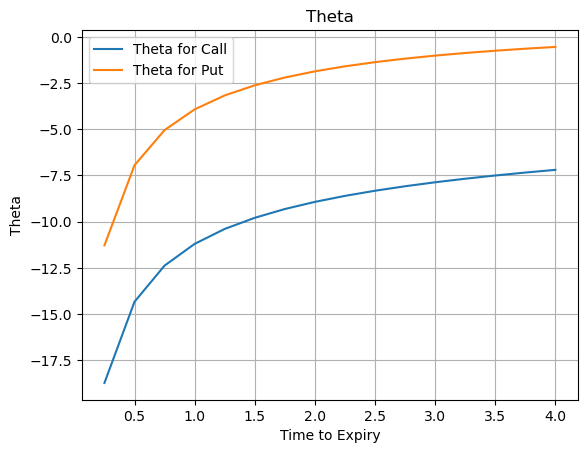

In [119]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

In [121]:
#Rho

def rho(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [123]:
rho(250, 250, 1, 0.03, 0.15, 'call')

133.37275122681717

In [125]:
rho(250, 250, 1, 0.03, 0.15, 'put')

-109.23863216030988

In [131]:
r = np.linspace(0,0.2,22)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(250, 250, 1, r[i], 0.15, 'call')
    Rho_Put [i] = rho(250, 250, 1, r[i], 0.15, 'put')

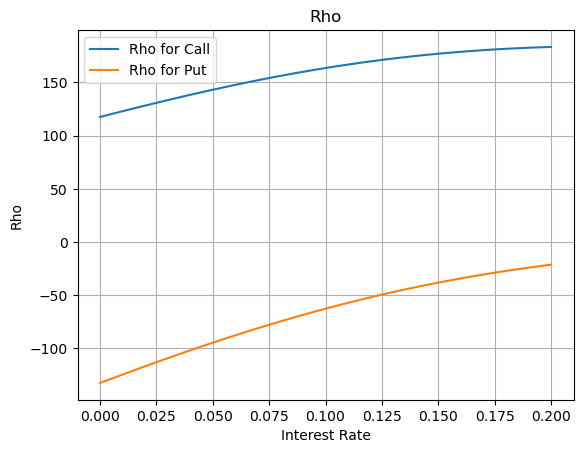

In [133]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [135]:
#Vega

def vega(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    vega = S * np.sqrt(T) * N_d1_prime
    
    return vega

In [137]:
vega(250, 250, 1, 0.03, 0.15, 'call')

96.03472882642619

In [139]:
vega(250, 250, 1, 0.03, 0.15, 'put')

96.03472882642619

In [141]:
vol = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(250, 250, 1, 0.03, vol[i], 'call')

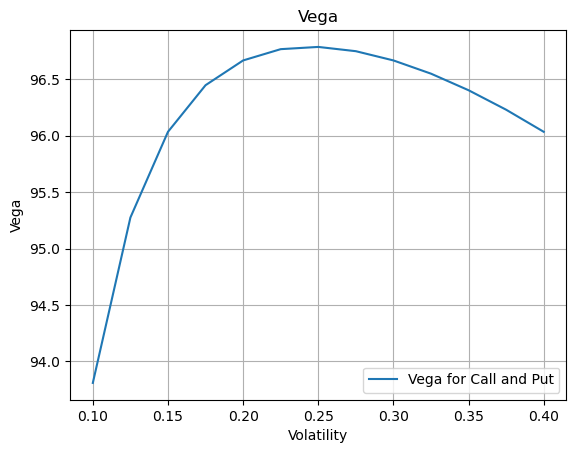

In [143]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [173]:
# Q2 

In [35]:
#Implied Volatility

def newton_vol_call(S, K, T, C, r):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: risk free rate
    #sigma: volatility of underlying asset
   
    MAX_ITERATIONS = 10000
    tolerance = 0.000001
    
    sigma = 0.15
    
    for i in range(0, MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)

        diff = C - price

        if (abs(diff) < tolerance):
            return sigma
        else: 
            sigma = sigma + diff/vega
        
        # print(i,sigma,diff)
        
    return sigma

In [37]:
PDD = yf.Ticker("PDD")
opt = PDD.option_chain('2025-05-16')
opt.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,PDD250516C00070000,2025-01-28 14:49:13+00:00,70.0,41.50,43.40,46.45,0.000000,0.000000,1,1,0.000010,True,REGULAR,USD
1,PDD250516C00075000,2025-01-27 15:40:11+00:00,75.0,36.85,38.75,41.95,0.000000,0.000000,1,2,0.000010,True,REGULAR,USD
2,PDD250516C00080000,2025-03-14 19:50:23+00:00,80.0,44.00,39.40,42.25,0.000000,0.000000,3,5,0.646488,True,REGULAR,USD
3,PDD250516C00085000,2025-01-27 20:38:56+00:00,85.0,29.30,30.75,31.80,0.000000,0.000000,1,5,0.000010,True,REGULAR,USD
4,PDD250516C00090000,2025-03-20 14:19:28+00:00,90.0,39.55,30.40,32.40,0.000000,0.000000,51,89,0.600834,True,REGULAR,USD
5,PDD250516C00095000,2025-03-20 18:11:14+00:00,95.0,36.80,26.55,26.80,0.000000,0.000000,18,262,0.550786,True,REGULAR,USD
6,PDD250516C00100000,2025-03-24 14:54:25+00:00,100.0,28.98,21.00,22.25,0.000000,0.000000,2,402,0.523686,True,REGULAR,USD
7,PDD250516C00105000,2025-03-27 17:47:33+00:00,105.0,17.50,17.75,18.65,-3.400000,-16.267940,1,799,0.509282,True,REGULAR,USD
8,PDD250516C00110000,2025-03-28 16:00:29+00:00,110.0,13.25,13.90,14.05,-4.100000,-23.631126,16,1854,0.464361,True,REGULAR,USD
9,PDD250516C00115000,2025-03-27 14:44:51+00:00,115.0,9.60,10.50,10.65,-4.049999,-29.670324,7,1576,0.447759,True,REGULAR,USD


In [49]:
impvol = newton_vol_call(120, 130, 4/52, float(opt.calls.lastPrice[opt.calls.strike == 130.00].iloc[0]), 0.03)
print('The implied volatility is', round(impvol*100,2) , '% with strike $ 130.00' ) 

The implied volatility is nan % with strike $ 130.00


/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_3554/2367034071.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = sigma + diff/vega
/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_3554/2367034071.py:18: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_3554/2367034071.py:19: RuntimeWarning: invalid value encountered in scalar divide
  d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [53]:
def newton_vol_put(S, K, T, P, r):
    MAX_ITERATIONS = 10000
    tolerance = 0.000001
    sigma = 0.15

    for i in range(MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
        vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)
        diff = P - price

        if abs(diff) < tolerance:
            return sigma
        sigma += diff / vega

    return sigma

In [55]:
TESLA = yf.Ticker("TSLA")
opt = TESLA.option_chain('2025-06-20')
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA250620P00005000,2025-03-28 18:46:25+00:00,5.0,0.01,0.00,0.01,0.00,0.000000,105.0,19497,2.500004,False,REGULAR,USD
1,TSLA250620P00010000,2025-03-26 19:12:23+00:00,10.0,0.01,0.00,0.01,0.00,0.000000,10.0,9996,2.062505,False,REGULAR,USD
2,TSLA250620P00015000,2025-03-28 18:27:21+00:00,15.0,0.02,0.02,0.03,0.01,100.000000,84.0,19323,2.031255,False,REGULAR,USD
3,TSLA250620P00020000,2025-03-28 19:01:27+00:00,20.0,0.05,0.03,0.05,0.01,25.000006,819.0,19889,1.906250,False,REGULAR,USD
4,TSLA250620P00025000,2025-03-28 19:00:48+00:00,25.0,0.08,0.07,0.09,0.02,33.333336,1146.0,20684,1.859376,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TSLA250620P00920000,2025-02-05 16:36:35+00:00,920.0,537.90,655.55,659.30,0.00,0.000000,2.0,0,1.146733,True,REGULAR,USD
125,TSLA250620P00930000,2024-12-19 20:34:13+00:00,930.0,497.30,533.80,537.00,0.00,0.000000,NaN,0,0.000010,True,REGULAR,USD
126,TSLA250620P00940000,2025-02-06 14:40:12+00:00,940.0,570.90,675.55,679.30,0.00,0.000000,1.0,0,1.162358,True,REGULAR,USD
127,TSLA250620P00950000,2025-01-29 20:41:09+00:00,950.0,561.20,654.85,659.20,0.00,0.000000,2.0,0,0.000010,True,REGULAR,USD


In [69]:
impvol = newton_vol_put(263, 250, 10/52, float(opt.puts.lastPrice[opt.puts.strike == 250.00].iloc[0]), 0.05)
print('The implied volatility is', round(impvol*100,2) , '% for the two and a half months put with strike $ 250.00' )

The implied volatility is 73.76 % for the two and a half months put with strike $ 250.00


In [67]:
impvol = newton_vol_put(263, 350, 10/52, float(opt.puts.lastPrice[opt.puts.strike == 350.00].iloc[0]), 0.05)
print('The implied volatility is', round(impvol*100,2) , '% for the two and a half months put with strike $ 350.00' )

The implied volatility is nan % for the two and a half months put with strike $ 350.00


/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_3554/1425312101.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  sigma += diff / vega
/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_3554/1425312101.py:7: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [71]:
TSLA = yf.download("TSLA", start="2024-03-30", end="2025-03-30")

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [73]:
S = TSLA['Close'].iloc[-1]
print('The close price is $', round(S,3), '.')

The close price is $ Ticker
TSLA    263.55
Name: 2025-03-28 00:00:00, dtype: float64 .


In [75]:
log_return = np.log(TSLA['Close'] / TSLA['Close'].shift(1))
vol_h = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is Ticker
TSLA    68.38
dtype: float64 %


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA250620P00005000,2025-03-21 17:56:00+00:00,5.0,0.01,0.00,0.01,0.00,0.000000,1136.0,18948,2.375004,False,REGULAR,USD
1,TSLA250620P00010000,2025-03-21 19:49:54+00:00,10.0,0.01,0.01,0.02,0.00,0.000000,254.0,9754,2.125005,False,REGULAR,USD
2,TSLA250620P00015000,2025-03-21 19:46:11+00:00,15.0,0.03,0.02,0.03,0.00,0.000000,206.0,18142,1.921875,False,REGULAR,USD
3,TSLA250620P00020000,2025-03-21 19:43:30+00:00,20.0,0.05,0.05,0.07,0.01,25.000006,675.0,13924,1.867188,False,REGULAR,USD
4,TSLA250620P00025000,2025-03-21 19:50:52+00:00,25.0,0.08,0.07,0.09,0.00,0.000000,156.0,10809,1.750001,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TSLA250620P00920000,2025-02-05 16:36:35+00:00,920.0,537.90,655.55,659.30,0.00,0.000000,2.0,0,0.000010,True,REGULAR,USD
125,TSLA250620P00930000,2024-12-19 20:34:13+00:00,930.0,497.30,533.80,537.00,0.00,0.000000,NaN,0,0.000010,True,REGULAR,USD
126,TSLA250620P00940000,2025-02-06 14:40:12+00:00,940.0,570.90,675.55,679.30,0.00,0.000000,1.0,0,0.000010,True,REGULAR,USD
127,TSLA250620P00950000,2025-01-29 20:41:09+00:00,950.0,561.20,654.85,659.20,0.00,0.000000,2.0,0,0.000010,True,REGULAR,USD
